In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model_path = "/content/drive/My Drive/Colab Notebooks/Deep_Learning_Project/Burger_PINN_model.pt"

cpu


In [3]:
# 1. Define the neural network
class BurgerPINN(nn.Module):
    def __init__(self, layers):
        super(BurgerPINN, self).__init__()
        self.layers = []
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(nn.Tanh())
        self.model = nn.Sequential(*self.layers)

    def forward(self, x, t):
        u = self.model(torch.cat([x, t], dim=1))
        return u

In [ ]:
# 2. Define the loss function with boundary and initial conditions
def compute_loss(model, x, t, u0, u1, x_for_initial_condition):

    x = x.clone().detach().requires_grad_(True).to(device)
    t = t.clone().detach().requires_grad_(True).to(device)
    u = model(x, t)

    # Use automatic differentiation to compute derivatives
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    # PDE residual
    f = u_t + u * u_x - (0.01 / torch.pi) * u_xx

    # Boundary conditions
    u_left = model(-1.0 * torch.ones_like(t), t)
    u_right = model(torch.ones_like(t), t)
    boundary_loss = torch.mean((u_left - u0)**2) + torch.mean((u_right - u1)**2)

    # Initial condition
    u_initial = model(x_for_initial_condition, torch.zeros_like(x_for_initial_condition))
    initial_condition = -torch.sin(torch.pi * x_for_initial_condition) # Here you need to define f(x) or provide the known values
    initial_loss = torch.mean((u_initial - initial_condition)**2)

    loss = torch.mean(f**2) + boundary_loss + initial_loss
    return loss


In [ ]:
def latin_hypercube_sampling(n: int, samples: int) -> torch.Tensor:
    """
    Latin Hypercube Sampling
    """
    lhs = torch.rand(samples, n).to(device) # uniform distribution on the interval [0,1)
    for d in range(n):
        # For each sample, randomly select a point in the corresponding interval
        lhs[:, d] = (torch.randperm(samples).to(device) + 1.0 - lhs[:, d]) / samples
    return lhs

In [ ]:
# Training
if __name__ == "__main__":
    layers = [2, 32, 32, 32, 32, 32, 32, 32, 1]
    model = BurgerPINN(layers).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Sample random points for training
    x = -1.0 + latin_hypercube_sampling(1, 10000) * 2.0
    t = latin_hypercube_sampling(1, 10000)

    # Boundary conditions
    u0 = torch.tensor([0.0]).to(device)  # Just an example value
    u1 = torch.tensor([0.0]).to(device)  # Just an example value

    # Initial condition
    x_for_initial_condition = -1.0 + latin_hypercube_sampling(1, 1000) * 2.0

    epochs = 10000
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = compute_loss(model, x, t, u0, u1, x_for_initial_condition)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            torch.save(model, model_path)
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch 100, Loss: 0.18223868310451508
Epoch 200, Loss: 0.13391098380088806
Epoch 300, Loss: 0.10898521542549133
Epoch 400, Loss: 0.10167419910430908
Epoch 500, Loss: 0.07962426543235779
Epoch 600, Loss: 0.06171143054962158
Epoch 700, Loss: 0.05584077537059784
Epoch 800, Loss: 0.052289701998233795
Epoch 900, Loss: 0.0432085357606411
Epoch 1000, Loss: 0.04176071286201477
Epoch 1100, Loss: 0.03358171880245209
Epoch 1200, Loss: 0.031335800886154175
Epoch 1300, Loss: 0.022804662585258484
Epoch 1400, Loss: 0.03044443391263485
Epoch 1500, Loss: 0.02130986377596855
Epoch 1600, Loss: 0.017326582223176956
Epoch 1700, Loss: 0.014531079679727554
Epoch 1800, Loss: 0.027267608791589737
Epoch 1900, Loss: 0.01197588350623846
Epoch 2000, Loss: 0.01009055320173502
Epoch 2100, Loss: 0.02050803415477276
Epoch 2200, Loss: 0.00833152700215578
Epoch 2300, Loss: 0.011124801822006702
Epoch 2400, Loss: 0.006791749969124794
Epoch 2500, Loss: 0.006021327339112759
Epoch 2600, Loss: 0.006174645386636257
Epoch 2700, 

In [4]:
# Load the the saved file
loaded_model = torch.load(model_path).to(device)

# Set the model to evaluation mode if you plan to use it for inference
loaded_model.eval()

len_eval = 1000

with torch.no_grad():
    x_eval = -1.0 + (torch.arange(1, len_eval + 1).to(device) / len_eval - (0.5 / len_eval)) * 2.0
    t_eval = torch.arange(1, len_eval + 1).to(device) / len_eval - (0.5 / len_eval)
    # Cartesian product
    all_points = torch.cartesian_prod(x_eval, t_eval).to(device) # (x, t)
    # torch.cartesian_prod: The behavior is similar to python’s itertools.product
    assert all_points.shape == (len_eval * len_eval, 2)
    all_results = loaded_model(all_points[:, 0:1], all_points[:, 1:2]).detach().squeeze()
    assert all_results.shape == torch.Size([len_eval * len_eval])

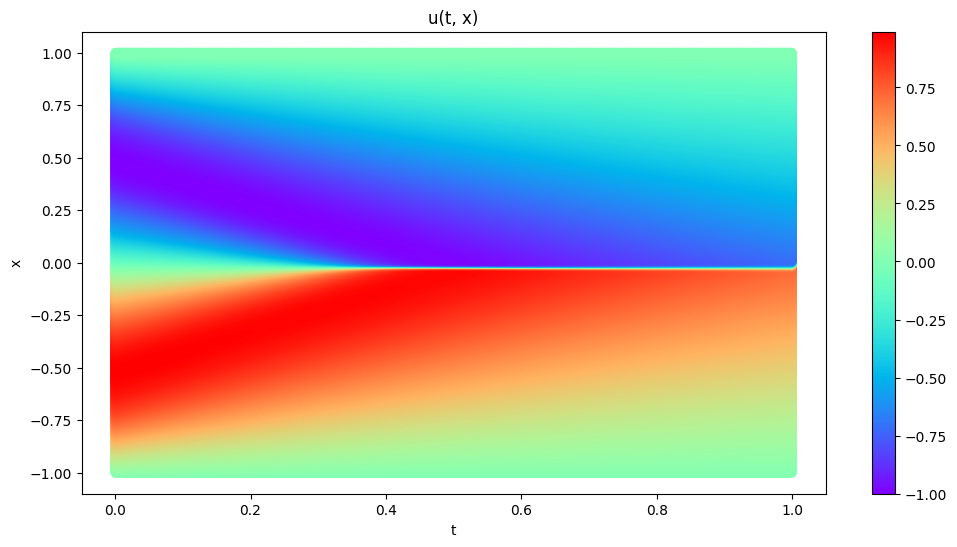

In [5]:
plt.figure(figsize=(12, 6))

# Create scatter plot
plt.scatter(all_points[:, 1:2].squeeze().cpu(), all_points[:, 0:1].squeeze().cpu(), c=all_results.cpu(), cmap='rainbow')

# Add a color bar
plt.colorbar()

# Add labels and title if needed
plt.xlabel('t')
plt.ylabel('x')
plt.title("u(t, x)")

# Show the plot
plt.show()

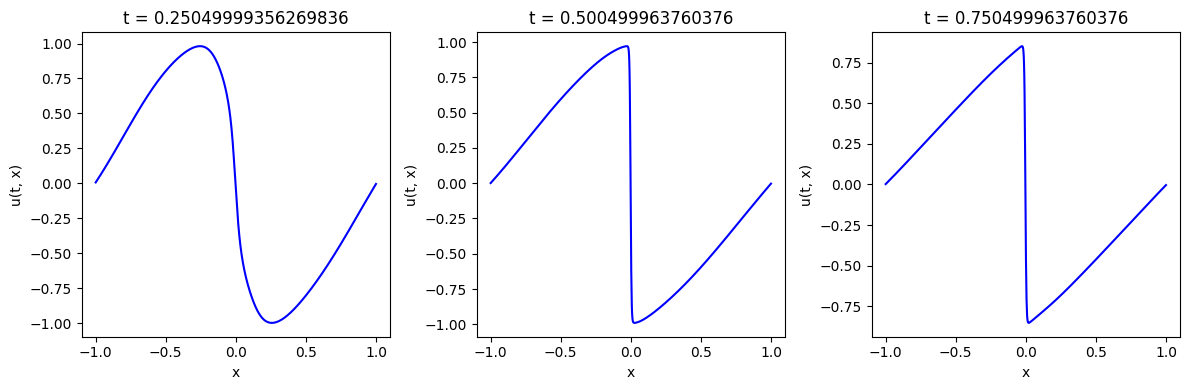

In [6]:
# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
t_1 = int(0.25 * len_eval)
ax1.plot(x_eval.cpu(), all_results[torch.tensor([i + t_1 for i in range(0, len_eval * len_eval, len_eval)]).to(device)].cpu(), 'b-')
ax1.set_title('t = ' + str(float(t_eval[t_1])))
ax1.set_xlabel('x')
ax1.set_ylabel('u(t, x)')

# Second subplot
t_2 = int(0.5 * len_eval)
ax2.plot(x_eval.cpu(), all_results[torch.tensor([i + t_2 for i in range(0, len_eval * len_eval, len_eval)]).to(device)].cpu(), 'b-')
ax2.set_title('t = ' + str(float(t_eval[t_2])))
ax2.set_xlabel('x')
ax2.set_ylabel('u(t, x)')

# Third subplot
t_3 = int(0.75 * len_eval)
ax3.plot(x_eval.cpu(), all_results[torch.tensor([i + t_3 for i in range(0, len_eval * len_eval, len_eval)]).to(device)].cpu(), 'b-')
ax3.set_title('t = ' + str(float(t_eval[t_3])))
ax3.set_xlabel('x')
ax3.set_ylabel('u(t, x)')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()